# Brain Tumour Detection using MRI

# Import packages

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset 
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import random

# Reading the images

In [4]:
tumour = []
path = './data/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, b, g])
    tumour.append(img)

In [5]:
healthy = []
path = './data/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, b, g])
    healthy.append(img)

In [6]:
healthy = np.array(healthy)
tumour = np.array(tumour)
all = np.concatenate((healthy, tumour))

In [7]:
all.shape

(251, 128, 128, 3)

# Visualizing Brain Images

In [8]:
def plot_random(healthy, tumour, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumour_imgs = tumour[np.random.choice(tumour.shape[0], num, replace=False)]
    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
        
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumour')
        plt.imshow(tumour_imgs[i])

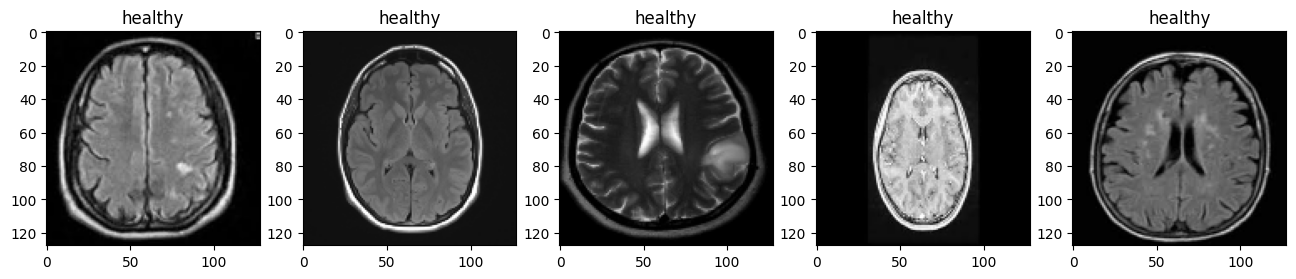

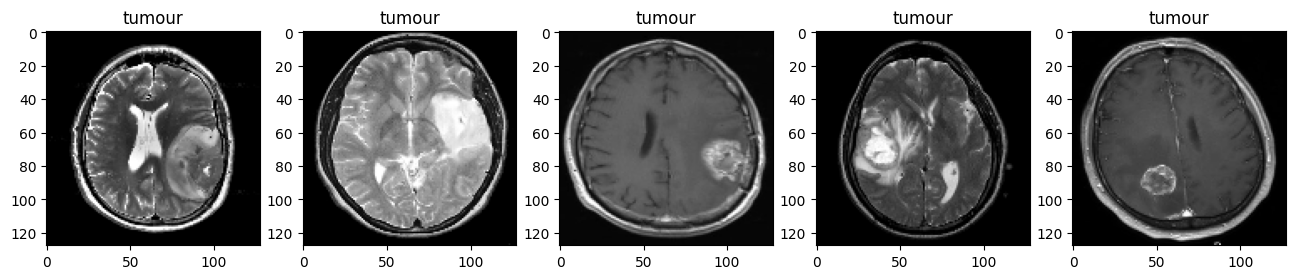

In [9]:
plot_random(healthy, tumour, num=5)

# Create Torch Dataset Class

## PyTorch Abstract Dataset Class

In [10]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

## Creating MRI custom dataset class

In [11]:
class MRI(Dataset):
    def __init__(self):
        
        tumour = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumour.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumour = np.array(tumour,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumour_label = np.ones(tumour.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumour, healthy), axis=0)
        self.labels = np.concatenate((tumour_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [12]:
mri_dataset = MRI()
mri_dataset.normalize()

## Creating a Dataloader

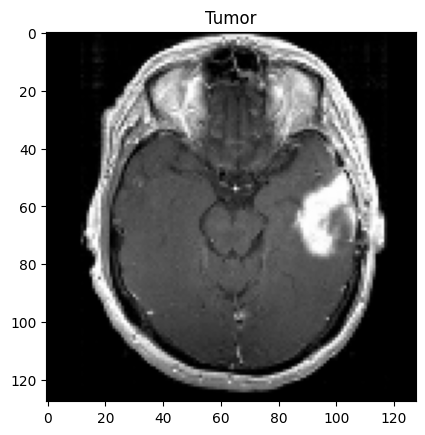

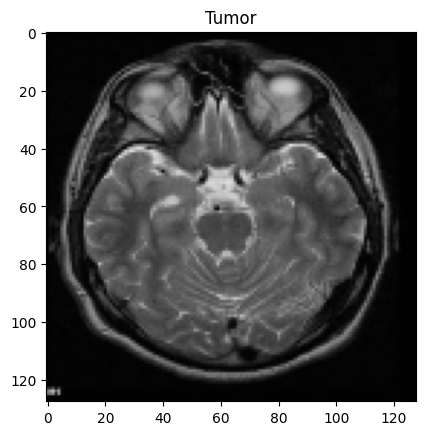

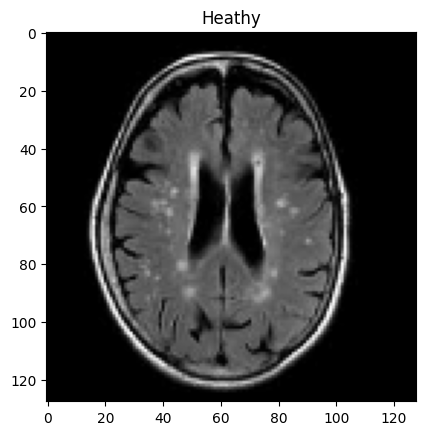

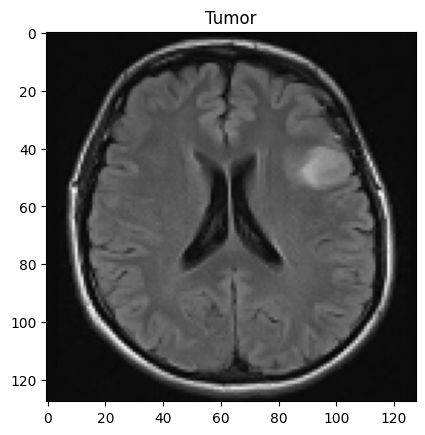

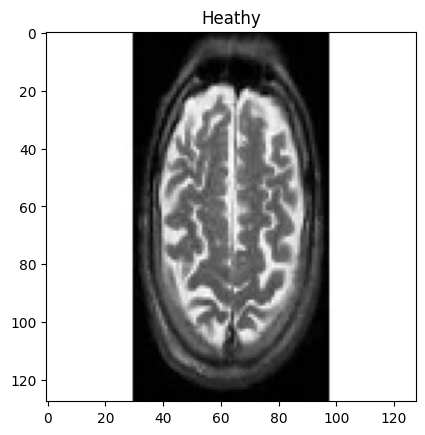

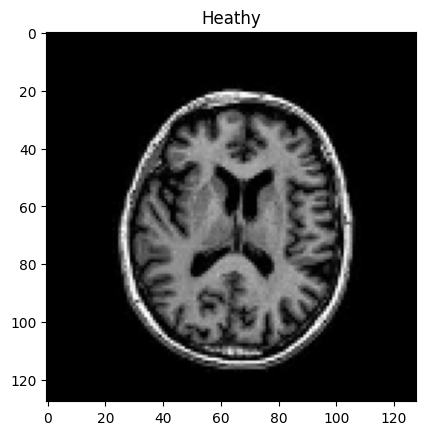

In [13]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# Create a Model

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

In [15]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.6125, 0.3912, 0.1382, 0.0547, 0.2324, 0.9072, 0.5629, 0.8149, 0.1799,
        0.0094]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.6125, 0.3912, 0.1382, 0.0547, 0.2324, 0.9072, 0.5629, 0.8149, 0.1799,
        0.0094]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([3.7521e-01, 1.5306e-01, 1.9095e-02, 2.9912e-03, 5.4008e-02, 8.2293e-01,
        3.1686e-01, 6.6401e-01, 3.2356e-02, 8.7895e-05])


## Evaluate a New-Born Neral Network

In [16]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu')
model = CNN().to(device)

In [17]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [18]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [19]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [20]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [21]:
accuracy_score(y_true, threshold(outputs))

0.38645418326693226

[Text(0, 0.5, 'Tumour'), Text(0, 1.5, 'Healthy')]

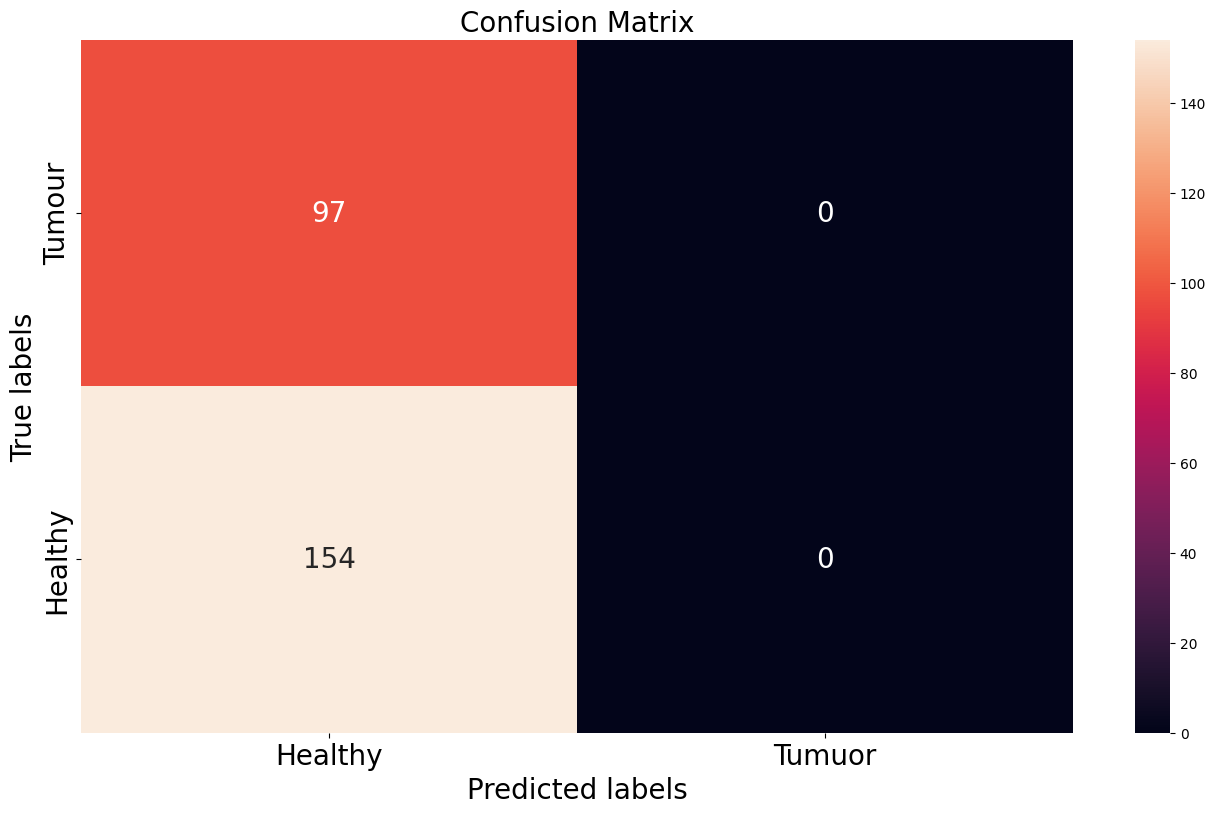

In [22]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumuor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumour','Healthy'], fontsize=20)

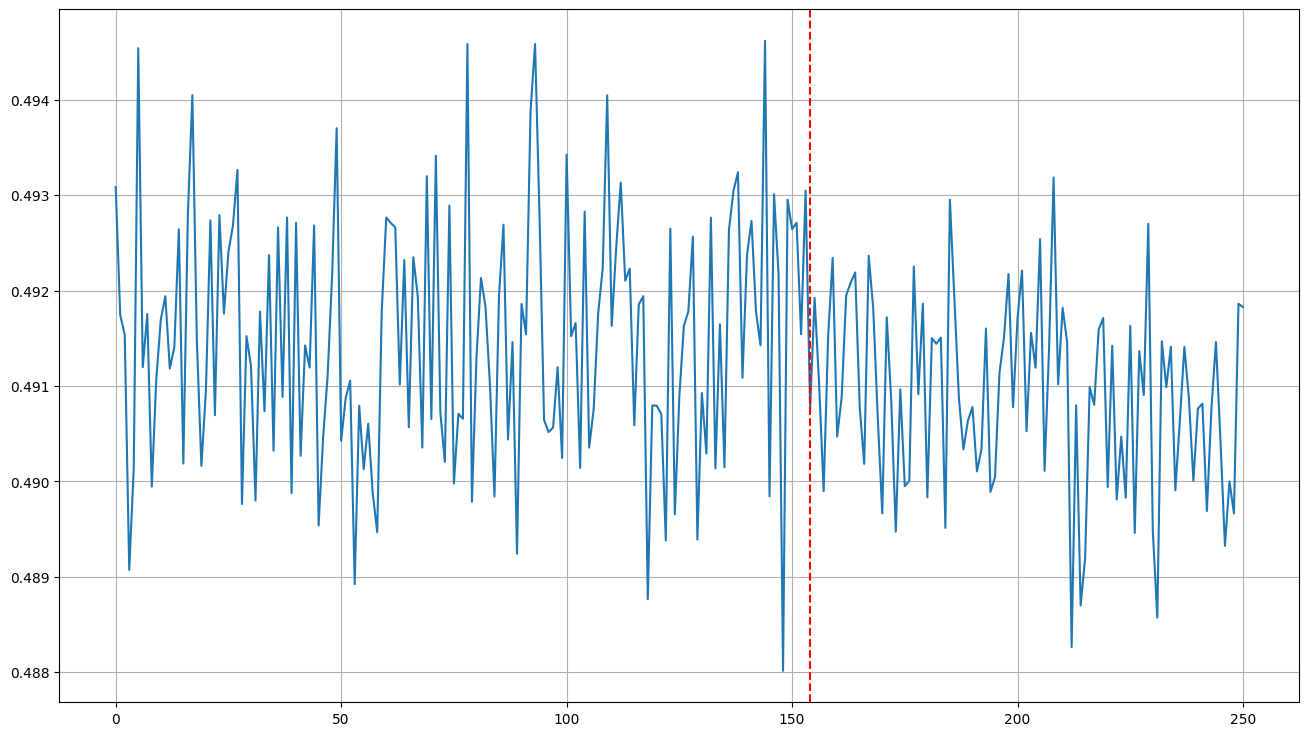

In [23]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumour), color='r', linestyle='--')
plt.grid()

## Train the dumb model

In [24]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [25]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.623309
Train Epoch: 20	Loss: 0.569986
Train Epoch: 30	Loss: 0.532874
Train Epoch: 40	Loss: 0.506572
Train Epoch: 50	Loss: 0.488764
Train Epoch: 60	Loss: 0.473674
Train Epoch: 70	Loss: 0.453412
Train Epoch: 80	Loss: 0.435864
Train Epoch: 90	Loss: 0.421314
Train Epoch: 100	Loss: 0.405378
Train Epoch: 110	Loss: 0.383928
Train Epoch: 120	Loss: 0.364428
Train Epoch: 130	Loss: 0.344688
Train Epoch: 140	Loss: 0.323262
Train Epoch: 150	Loss: 0.297956
Train Epoch: 160	Loss: 0.274237
Train Epoch: 170	Loss: 0.256687
Train Epoch: 180	Loss: 0.227715
Train Epoch: 190	Loss: 0.205725
Train Epoch: 200	Loss: 0.179984
Train Epoch: 210	Loss: 0.162987
Train Epoch: 220	Loss: 0.146862
Train Epoch: 230	Loss: 0.128329
Train Epoch: 240	Loss: 0.111804
Train Epoch: 250	Loss: 0.096742
Train Epoch: 260	Loss: 0.079233
Train Epoch: 270	Loss: 0.066276
Train Epoch: 280	Loss: 0.058084
Train Epoch: 290	Loss: 0.049480
Train Epoch: 300	Loss: 0.038507
Train Epoch: 310	Loss: 0.032726
Train Epoch: 320	

## Evaluate a smart model

In [26]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [27]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

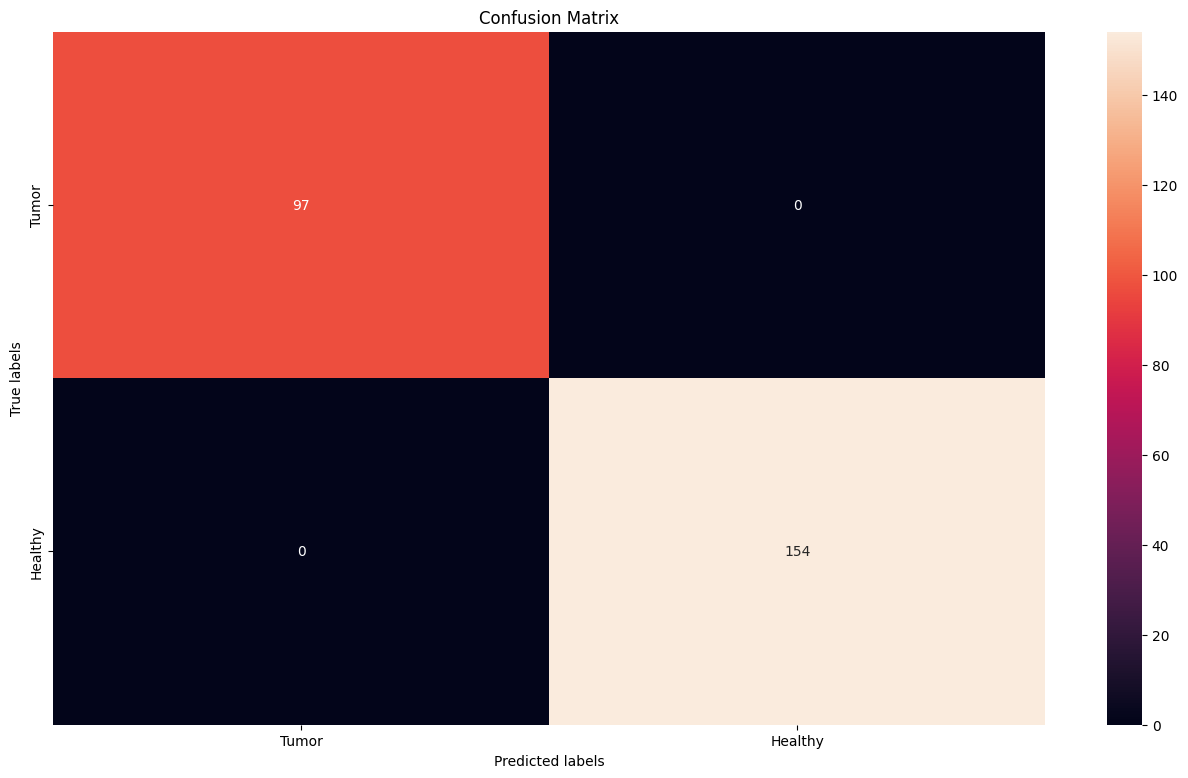

In [28]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

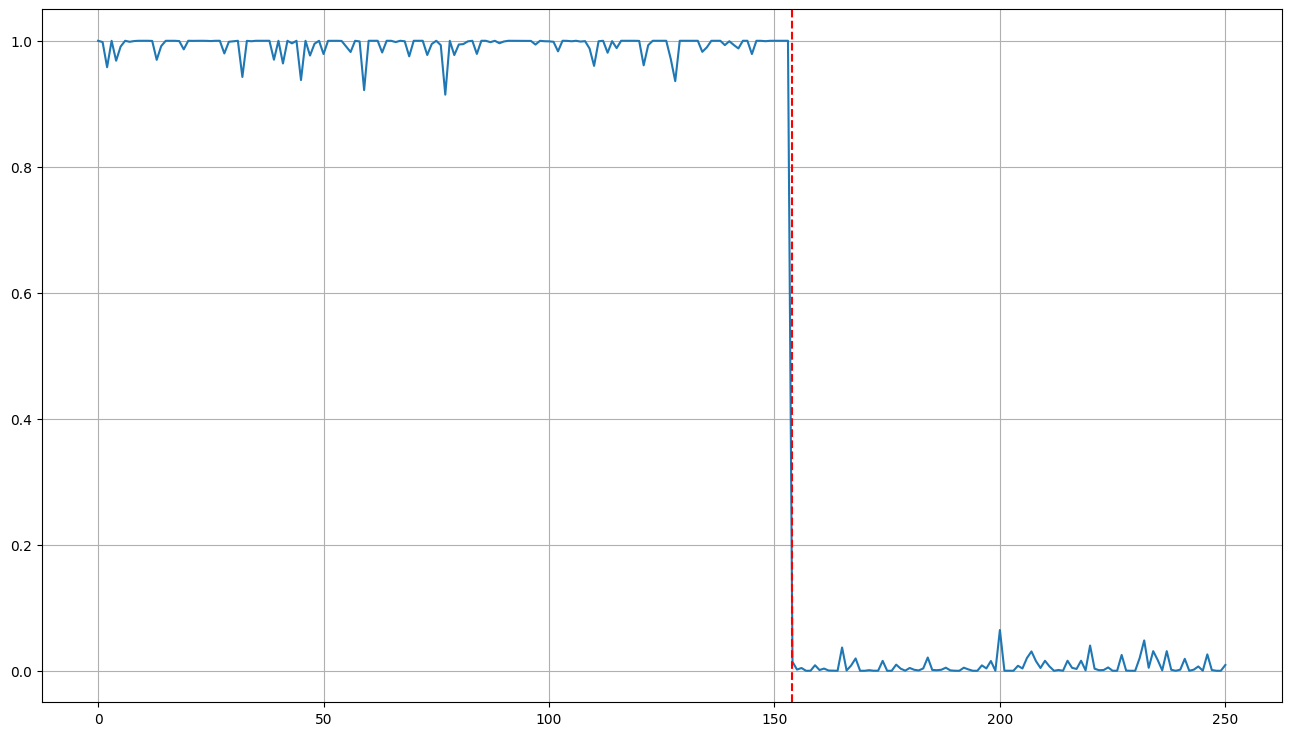

In [29]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumour), color='r', linestyle='--')
plt.grid()

## Visualising the Feature Maps of the Convolutional Filters

In [30]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [31]:
no_of_layers = 0
conv_layers = []

In [32]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [33]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [34]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

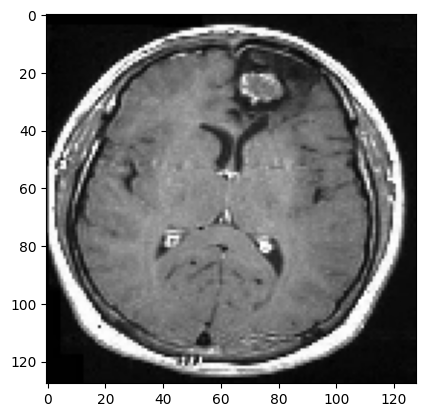

In [35]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [36]:
img = torch.from_numpy(img).to(device)

In [37]:
img.shape

torch.Size([3, 128, 128])

In [38]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [39]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


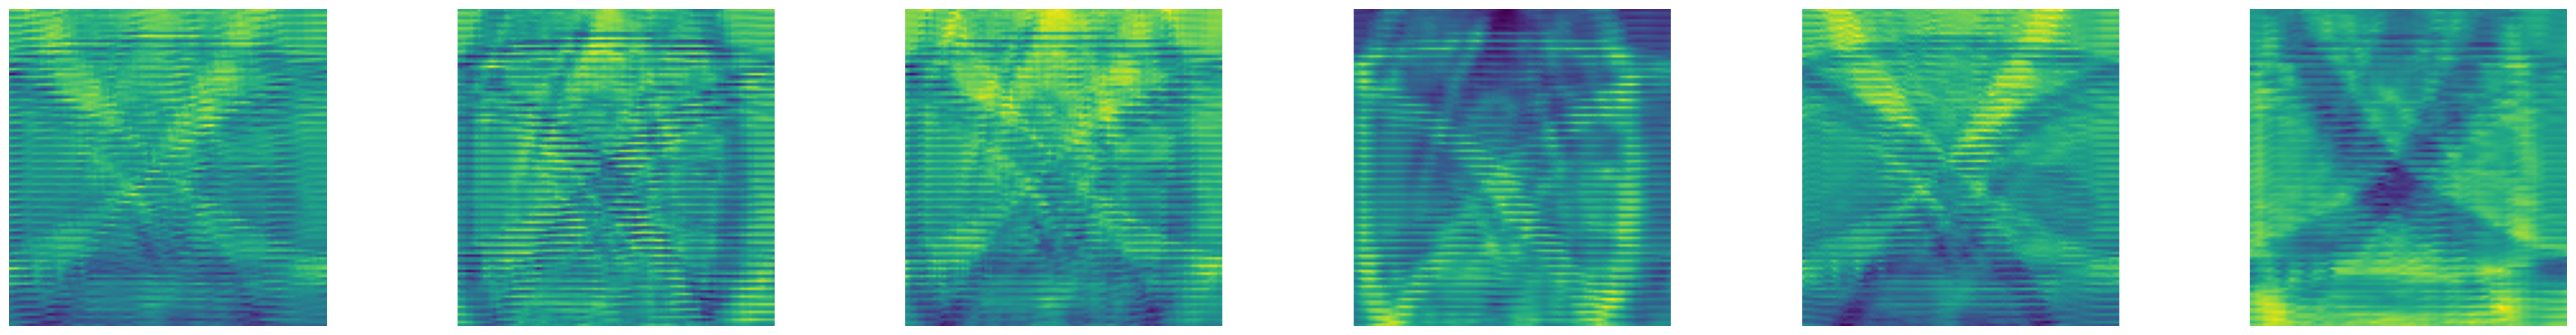

Layer  2


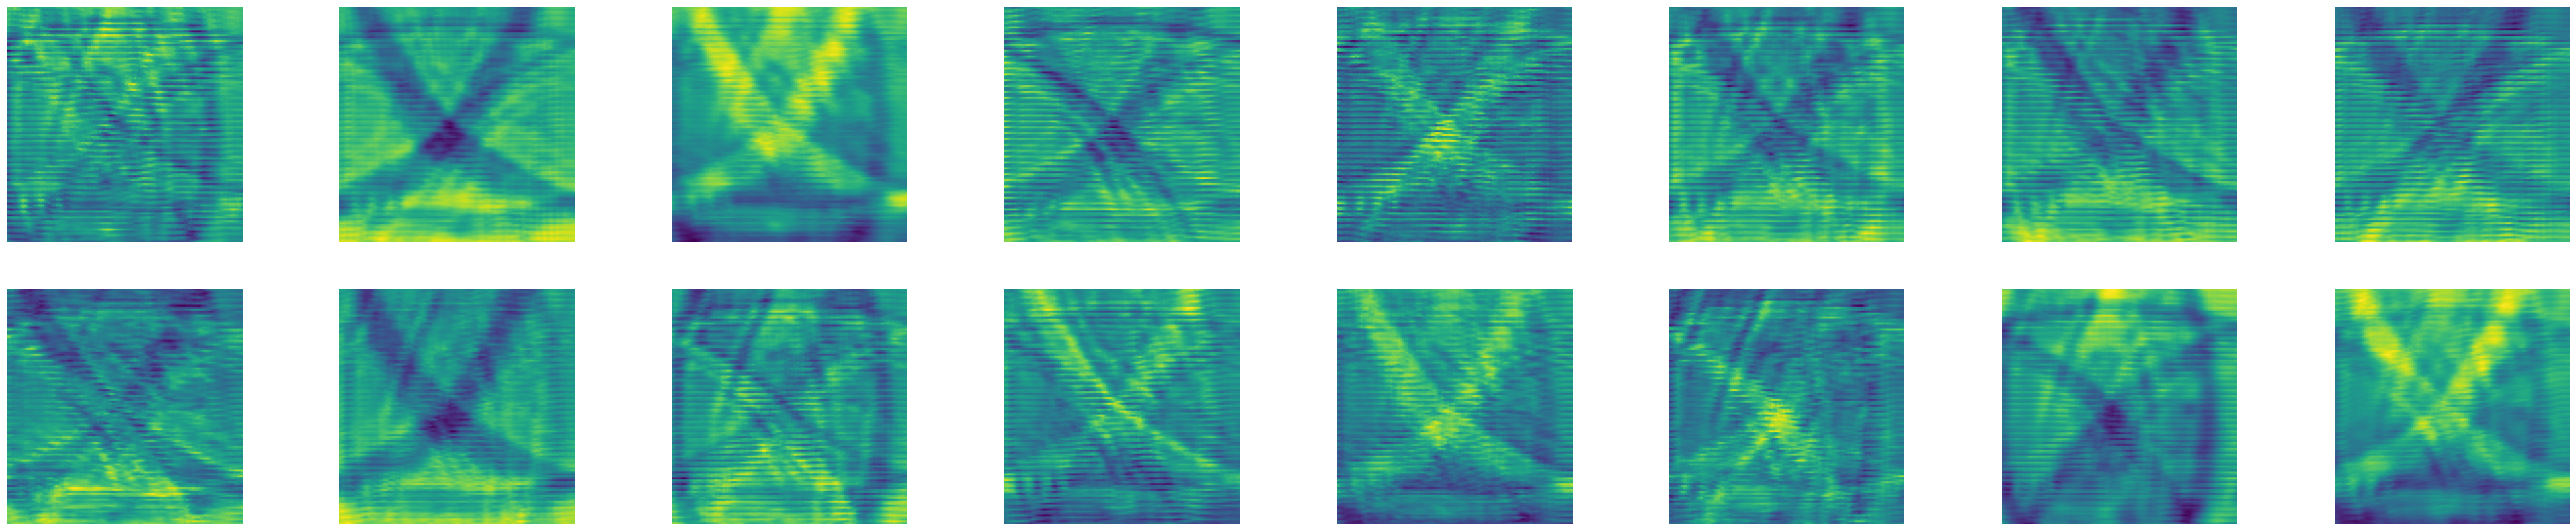

In [40]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

## Preparing a validation set

In [41]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [42]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

# Are we overfitting?

In [43]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [44]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [45]:
device = torch.device("cpu")
model = CNN().to(device)

In [46]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [47]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [48]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.608710	Val Loss: 0.626262
Train Epoch: 20	Train Loss: 0.536632	Val Loss: 0.631765
Train Epoch: 30	Train Loss: 0.513853	Val Loss: 0.669259
Train Epoch: 40	Train Loss: 0.505580	Val Loss: 0.667143
Train Epoch: 50	Train Loss: 0.453020	Val Loss: 0.656752
Train Epoch: 60	Train Loss: 0.424600	Val Loss: 0.650771
Train Epoch: 70	Train Loss: 0.418476	Val Loss: 0.639228
Train Epoch: 80	Train Loss: 0.397476	Val Loss: 0.635575
Train Epoch: 90	Train Loss: 0.381524	Val Loss: 0.644849
Train Epoch: 100	Train Loss: 0.397408	Val Loss: 0.677628
Train Epoch: 110	Train Loss: 0.347547	Val Loss: 0.668698
Train Epoch: 120	Train Loss: 0.356906	Val Loss: 0.672828
Train Epoch: 130	Train Loss: 0.335479	Val Loss: 0.682274
Train Epoch: 140	Train Loss: 0.320965	Val Loss: 0.703708
Train Epoch: 150	Train Loss: 0.305790	Val Loss: 0.702118
Train Epoch: 160	Train Loss: 0.285008	Val Loss: 0.723198
Train Epoch: 170	Train Loss: 0.232931	Val Loss: 0.772600
Train Epoch: 180	Train Loss: 0.239128	Va

Text(0, 0.5, 'Loss')

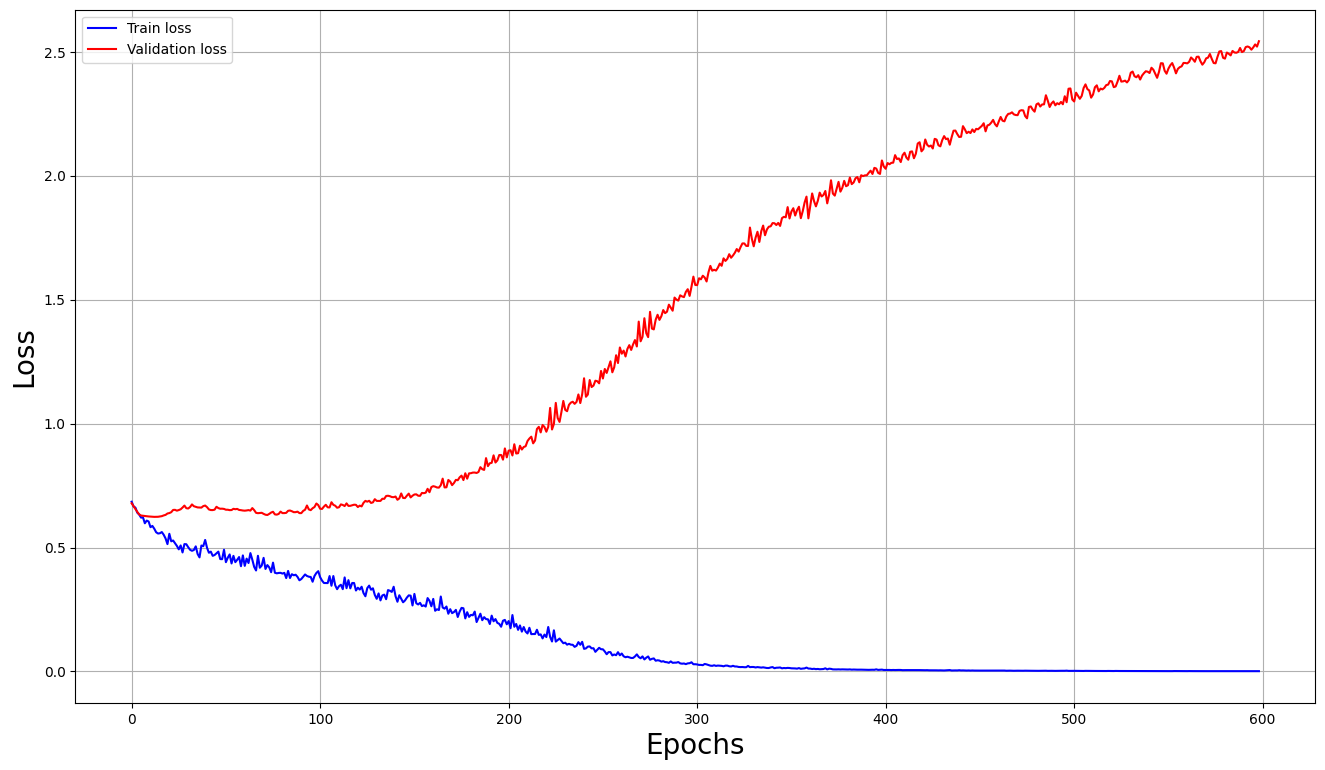

In [49]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)